In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
gdrive_path = '/content/drive/MyDrive/thesis'

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, MultiHeadAttention, Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras import utils
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import pandas as pd
import string
import re
import nltk
from textblob import TextBlob
from nltk.corpus import wordnet
from nltk.metrics import edit_distance
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import pickle
import itertools
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import gensim
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
whole_data = pd.read_csv("Supervised_whole_data.csv")
train_data = pd.read_csv("supervised_train_data.csv")
test_data = pd.read_csv("supervised_test_data.csv")

In [7]:
# WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 32
BATCH_SIZE = 1024

NORMAL = 0
ABNORMAL = 1
CLASSIFICATION_THRESHOLDS = (0.4, 0.7)

KERAS_MODEL = "lstm_w2v_cbow.sav"
WORD2VEC_MODEL = "model.w2v_cbow"
TOKENIZER_MODEL = "w2v_tokenizer_cbow.pkl"
ENCODER_MODEL = "encoder_cbow.pkl"

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [10]:
# TEXT CLEANING
TEXT_CLEANING = "@\S+|https?:\S+|http?:\S|[^A-Za-z]+"

def preprocess(text, stem=False):

    text = re.sub(TEXT_CLEANING, ' ', str(text).lower()).strip()
    tokens = []

    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)

    return " ".join(tokens)

In [11]:
whole_data.conclusion = whole_data.conclusion.apply(lambda x: preprocess(x))
train_data.conclusion = train_data.conclusion.apply(lambda x: preprocess(x))
test_data.conclusion = test_data.conclusion.apply(lambda x: preprocess(x))

In [12]:
whole_data.sample(10)

,conclusion,Abnormal
2112,background attenuated r rhythmic fast activity...,1.0
4114,diffuse slow background hz consistent moderate...,1.0
3991,eeg within normal boundaries,0.0
5890,eeg shows bifrontal delta waves hz reactive bi...,1.0
5213,eeg usual,0.0
2878,eeg within normal limitation,0.0
6015,eeg organized compared discharges l temporal r...,1.0
2674,eeg within normal confine,0.0
1104,epileptiform spills eeg normal,0.0
3671,eeg within normal limits,0.0


In [13]:
X_train, y_train = train_data["conclusion"].values, train_data["Abnormal"].values
X_test, y_test = test_data["conclusion"].values, test_data["Abnormal"].values

In [14]:
documents = [_text.split() for _text in whole_data.conclusion]
print(len(documents))

6448


In [15]:
cbow_w2v = gensim.models.Word2Vec(documents, vector_size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=8, sg=0)

In [16]:
words = cbow_w2v.wv.index_to_key
vocab_size_wv = len(words)
print("Vocab size:", vocab_size_wv)

Vocab size: 473


In [17]:
cbow_w2v.wv.most_similar("abnormal")

[('mildly', 0.9802889823913574),
 ('bitemporal', 0.977083146572113),
 ('intermittent', 0.9722883701324463),
 ('occasionally', 0.9697809219360352),
 ('independent', 0.969264805316925),
 ('wave', 0.956015408039093),
 ('frontotemporal', 0.9557210803031921),
 ('r', 0.9540466666221619),
 ('central', 0.9532929062843323),
 ('isolated', 0.9507589936256409)]

In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(whole_data.conclusion)

In [19]:
vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 2237


In [20]:
x_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=SEQUENCE_LENGTH)

In [21]:
encoder = LabelEncoder()
encoder.fit(whole_data.Abnormal.tolist())
y_train = encoder.transform(y_train.tolist())
y_test = encoder.transform(y_test.tolist())
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (5948, 1)
y_test (500, 1)


In [22]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (5948, 300)
y_train (5948, 1)

x_test (500, 300)
y_test (500, 1)


In [23]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
 if word in cbow_w2v.wv:
    embedding_matrix[i] = cbow_w2v.wv[word]
print(embedding_matrix.shape)

(2237, 300)


In [24]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [39]:
bilstm_model = Sequential()
bilstm_model.add(embedding_layer)
bilstm_model.add(Dropout(0.5))
bilstm_model.add(Bidirectional(LSTM(50, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
bilstm_model.add(Dropout(0.5))
bilstm_model.add(Bidirectional(LSTM(50, dropout=0.2, recurrent_dropout=0.2)))
bilstm_model.add(Dense(1, activation='sigmoid', kernel_regularizer='l1'))
bilstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          671100    
                                                                 
 dropout_2 (Dropout)         (None, 300, 300)          0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 300, 100)          140400    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 300, 100)          0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 100)               60400     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 1)                

In [40]:
bilstm_model.compile(loss='binary_crossentropy',
                    optimizer="adam",
                    metrics=["accuracy"])

In [41]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [42]:
history = bilstm_model.fit(x_train, y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_split=0.1,
                         verbose=1,
                         callbacks=callbacks)

bilstm_model.save(KERAS_MODEL)
bilstm_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

Epoch 1/32
6/6 [==============================] - 37s 4s/step - loss: 0.7087 - accuracy: 0.7693 - val_loss: 0.5211 - val_accuracy: 0.9126 - lr: 0.0010
Epoch 2/32
6/6 [==============================] - 24s 4s/step - loss: 0.4485 - accuracy: 0.9486 - val_loss: 0.3297 - val_accuracy: 0.9529 - lr: 0.0010
Epoch 3/32
6/6 [==============================] - 22s 4s/step - loss: 0.2942 - accuracy: 0.9608 - val_loss: 0.2798 - val_accuracy: 0.9496 - lr: 0.0010
Epoch 4/32
6/6 [==============================] - 23s 4s/step - loss: 0.2584 - accuracy: 0.9572 - val_loss: 0.2603 - val_accuracy: 0.9546 - lr: 0.0010
Epoch 5/32
6/6 [==============================] - 23s 4s/step - loss: 0.2401 - accuracy: 0.9626 - val_loss: 0.2513 - val_accuracy: 0.9513 - lr: 0.0010
Epoch 6/32
6/6 [==============================] - 23s 4s/step - loss: 0.2282 - accuracy: 0.9651 - val_loss: 0.2325 - val_accuracy: 0.9597 - lr: 0.0010
Epoch 7/32
6/6 [==============================] - 22s 4s/step - loss: 0.2175 - accuracy: 0.966

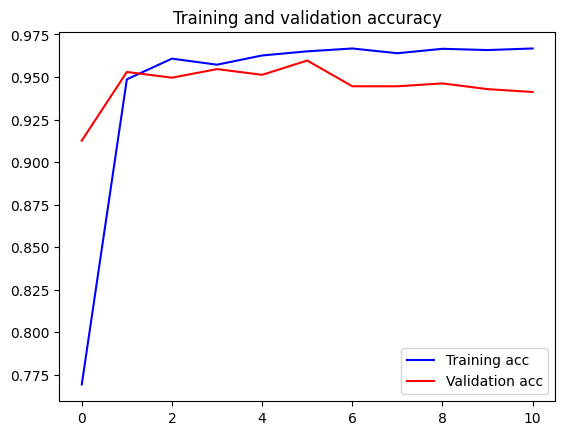

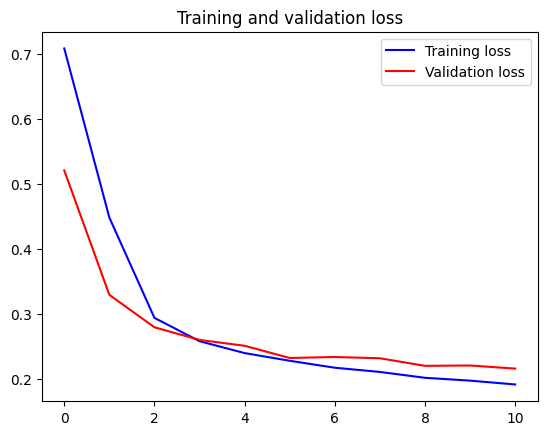

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [44]:
%%time
score = bilstm_model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

1/1 [==============================] - 0s 370ms/step - loss: 0.1746 - accuracy: 0.9760

ACCURACY: 0.9760000109672546
LOSS: 0.1745820790529251
CPU times: user 412 ms, sys: 19 ms, total: 431 ms
Wall time: 430 ms


In [45]:
def decode_prediction(score):
  return NORMAL if score < 0.5 else ABNORMAL

In [46]:
%%time
y_pred_1d = []
y_test_1d = list(y_test)
scores = bilstm_model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_prediction(score) for score in scores]

1/1 [==============================] - 1s 1s/step
CPU times: user 1.16 s, sys: 15.7 ms, total: 1.18 s
Wall time: 1.45 s


In [47]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title, fontsize=30)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
  plt.yticks(tick_marks, classes, fontsize=22)

  fmt = '.2f'
  thresh = cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

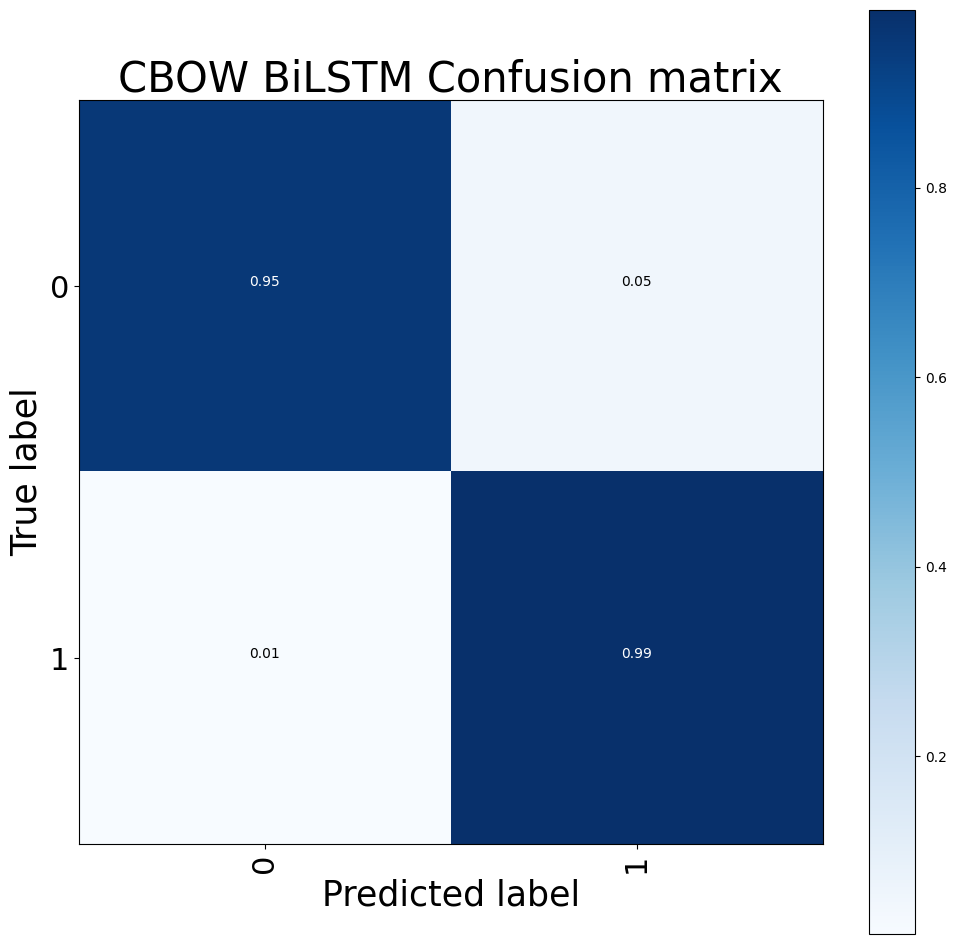

CPU times: user 403 ms, sys: 250 ms, total: 653 ms
Wall time: 454 ms


In [48]:
%%time
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=np.unique(y_train), title="CBOW BiLSTM Confusion matrix")
plt.show()

In [49]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       176
           1       0.98      0.99      0.98       324

    accuracy                           0.98       500
   macro avg       0.98      0.97      0.97       500
weighted avg       0.98      0.98      0.98       500



In [50]:
accuracy_score(y_test_1d, y_pred_1d)

0.976

In [51]:
bilstm_model.save(f"{gdrive_path}{KERAS_MODEL}")
cbow_w2v.save(f"{gdrive_path}{WORD2VEC_MODEL}")
pickle.dump(tokenizer, open(f"{gdrive_path}{TOKENIZER_MODEL}", "wb"), protocol=0)
pickle.dump(encoder, open(f"{gdrive_path}{ENCODER_MODEL}", "wb"), protocol=0)

In [53]:
# download the trained model
import shutil
shutil.make_archive("/content/drive/MyDrive/thesis", 'zip', "/content/drive/MyDrive/thesis")
from google.colab import files
files.download("/content/drive/MyDrive/thesis.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>